<a href="https://colab.research.google.com/github/Huxwell/ColabNNs/blob/main/cats_n_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from tqdm import tqdm
from PIL import Image
import random # do random.seed(13) before every shuffle. order of shuffle() execution changes results order.

Notes:
- I have no labels for test here, so I am dropping 'test.zip' related code. I can split train into train, val, test; in fact I don't want to have a lot of examples for train set.
- The sets are almost balanced, accuracy is ok here

In [2]:
!nvidia-smi

Wed Dec 14 20:23:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    33W /  70W |      0MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(13)
if device =='cuda':
    torch.cuda.manual_seed_all(13)

In [4]:
dataset_dir = '/content/drive/MyDrive/cats_n_dogs_unsure/dogs-vs-cats-redux-kernels-edition'
os.listdir(dataset_dir)

['sample_submission.csv', 'test.zip', 'train.zip']

In [5]:
os.makedirs('local_data/', exist_ok=True)
train_dir = 'local_data/train'

In [6]:
with zipfile.ZipFile(os.path.join(dataset_dir, 'train.zip')) as train_zip:
    train_zip.extractall('local_data')

In [7]:
os.listdir(train_dir)[:5]

['cat.5754.jpg', 'cat.7128.jpg', 'cat.703.jpg', 'dog.3914.jpg', 'cat.567.jpg']

In [8]:
cats_list = sorted(glob.glob(os.path.join(train_dir,'cat*.jpg')))
dogs_list = sorted(glob.glob(os.path.join(train_dir,'dog*.jpg')))
print(len(cats_list))
print(len(dogs_list))
random.seed(13)
random.shuffle(cats_list)
random.seed(13) #multiple seed() executions are on purpose.
random.shuffle(dogs_list)
print(cats_list[:3])
print(dogs_list[:3])
# some sanity check to make sure no uncontrolled randomness beyond this point
assert cats_list[2] == 'local_data/train/cat.801.jpg'
assert dogs_list[2] == 'local_data/train/dog.801.jpg'
assert len(cats_list) == len(dogs_list)


12500
12500
['local_data/train/cat.8473.jpg', 'local_data/train/cat.3808.jpg', 'local_data/train/cat.801.jpg']
['local_data/train/dog.8473.jpg', 'local_data/train/dog.3808.jpg', 'local_data/train/dog.801.jpg']


In [9]:
full_train_list = cats_list[:7500] + dogs_list[:7500]
# subset_train_list = cats_list[:500] + dogs_list[:500]
# subset_train_list = cats_list[:2000] + dogs_list[:2000]
# subset_train_list = cats_list[:250] + dogs_list[:250]
# subset_train_list = cats_list[:150] + dogs_list[:150]
subset_train_list = cats_list[:50] + dogs_list[:50]
val_list = cats_list[7500:10000] + dogs_list[7500:10000]
test_list = cats_list[10000:] + dogs_list[10000:]
print(len(subset_train_list),len(full_train_list), len(val_list), len(test_list))

random.seed(13)
random.shuffle(full_train_list)
random.seed(13)
random.shuffle(subset_train_list)
random.seed(13)
random.shuffle(val_list)
random.seed(13)
random.shuffle(test_list)
print("full",full_train_list[:9])
print("subset",subset_train_list[:9])
print("val",val_list[:9])
print("test",test_list[:9])
assert full_train_list[4] == 'local_data/train/cat.1612.jpg'
# assert subset_train_list[4] == 'local_data/train/cat.1787.jpg' #500imgs train
# assert subset_train_list[4] == 'local_data/train/cat.5360.jpg' #4000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.445.jpg' # 1000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.7661.jpg' # 300 imgs
assert subset_train_list[4] == 'local_data/train/cat.9914.jpg' #100 imgs
# assert subset_train_list[4] == 'local_data/train/dog.11151.jpg'#2000imgs train
assert val_list[4] == 'local_data/train/dog.12023.jpg'
assert test_list[4] == 'local_data/train/dog.6485.jpg'

100 15000 5000 5000
full ['local_data/train/dog.599.jpg', 'local_data/train/dog.1470.jpg', 'local_data/train/cat.682.jpg', 'local_data/train/dog.7470.jpg', 'local_data/train/cat.1612.jpg', 'local_data/train/cat.5301.jpg', 'local_data/train/dog.8695.jpg', 'local_data/train/cat.210.jpg', 'local_data/train/dog.10388.jpg']
subset ['local_data/train/cat.10248.jpg', 'local_data/train/dog.5860.jpg', 'local_data/train/cat.12496.jpg', 'local_data/train/dog.9372.jpg', 'local_data/train/cat.9914.jpg', 'local_data/train/cat.11478.jpg', 'local_data/train/dog.2589.jpg', 'local_data/train/cat.2534.jpg', 'local_data/train/dog.9914.jpg']
val ['local_data/train/dog.586.jpg', 'local_data/train/dog.1669.jpg', 'local_data/train/cat.1066.jpg', 'local_data/train/dog.5798.jpg', 'local_data/train/dog.12023.jpg', 'local_data/train/cat.10748.jpg', 'local_data/train/cat.1815.jpg', 'local_data/train/dog.5218.jpg', 'local_data/train/dog.5240.jpg']
test ['local_data/train/dog.1856.jpg', 'local_data/train/dog.10017.j

In [10]:
train_list = subset_train_list # 5 batches # or 20 batches
# train_list = full_train_list

[39 70 16 82 80 81 77 59  4  3]


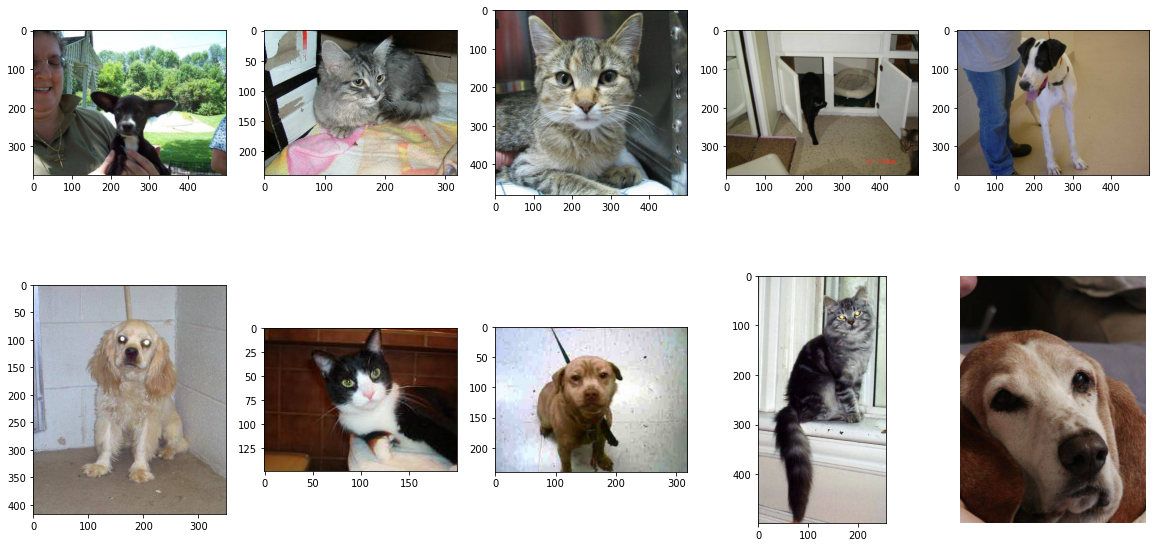

In [11]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [12]:
train_list[0].split('/')[-1].split('.')[0]

'cat'

# Data Augmentation

In [13]:
train_transforms =  transforms.Compose([ #these params work well for cats & dogs.:
  # transforms.Resize((224, 224)),
  transforms.RandomResizedCrop(224,scale=(0.9, 1.0)), 
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=.4, hue=.15),
  transforms.ToTensor(),
])

val_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transforms = transforms.Compose([   
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

In [14]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [15]:
## Visualization of Image Classification 
import torchvision
def visualize_classification(loader_iter, nrofItems = 9, pad = 0) -> None:

  #Iterate through the data loader
  imgTensor, labels = next(loader_iter)
  labels = labels.tolist()

  # Generate image grid
  grid = torchvision.utils.make_grid(imgTensor[:nrofItems], padding = pad, nrow=nrofItems)

  # Permute the axis as numpy expects image of shape (H x W x C) 
  grid = grid.permute(1, 2, 0)
  
  # Set up plot config
  plt.figure(figsize=(8, 2), dpi=300)
  plt.axis('off')

  # Plot Image Grid
  plt.imshow(grid)
  
  # # Plot the image titles
  # fact = 1 + (nrofItems)/100
  # rng = np.linspace(1/(fact*nrofItems), 1 - 1/(fact*nrofItems) , num = nrofItems)
  # for idx, val in enumerate(rng):
  #   plt.figtext(val, 0.85, labels[idx], fontsize=8)

  # Show the plot
  plt.show()

In [16]:
batch_size = 100 # we will use mini-batch method

In [17]:
train_data = dataset(train_list, transform=train_transforms)
val_data = dataset(val_list, transform=val_transforms)
test_data = dataset(test_list, transform=test_transforms)
visualise_train_dataset = dataset(train_list, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
vis_train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=False)

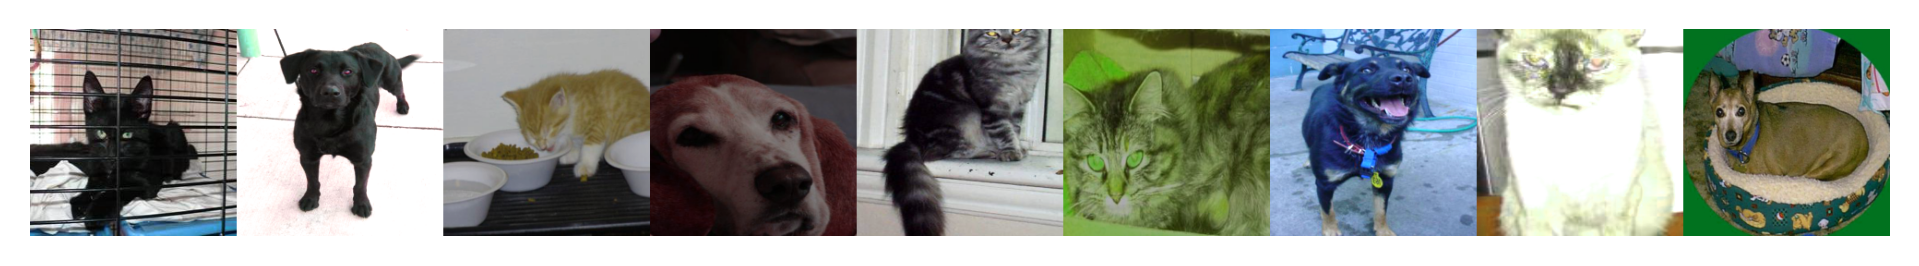

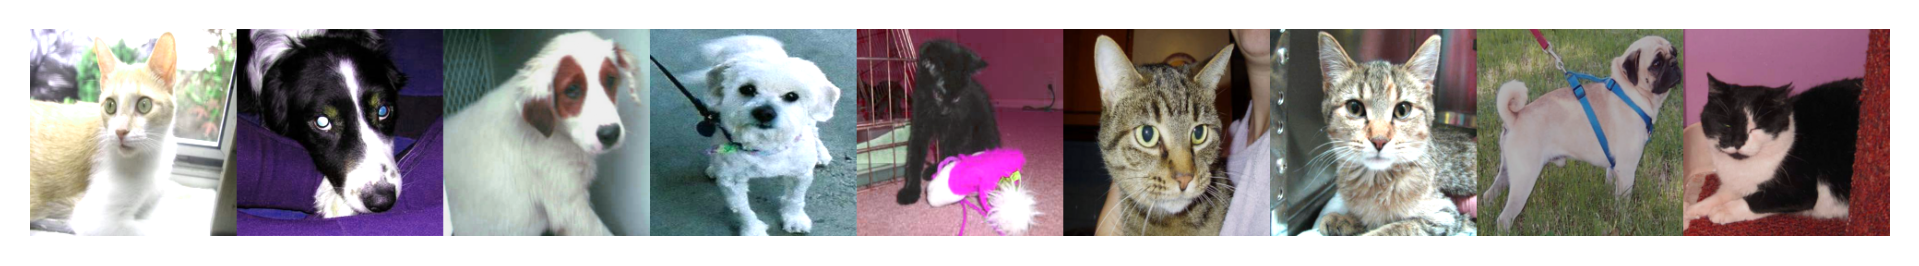

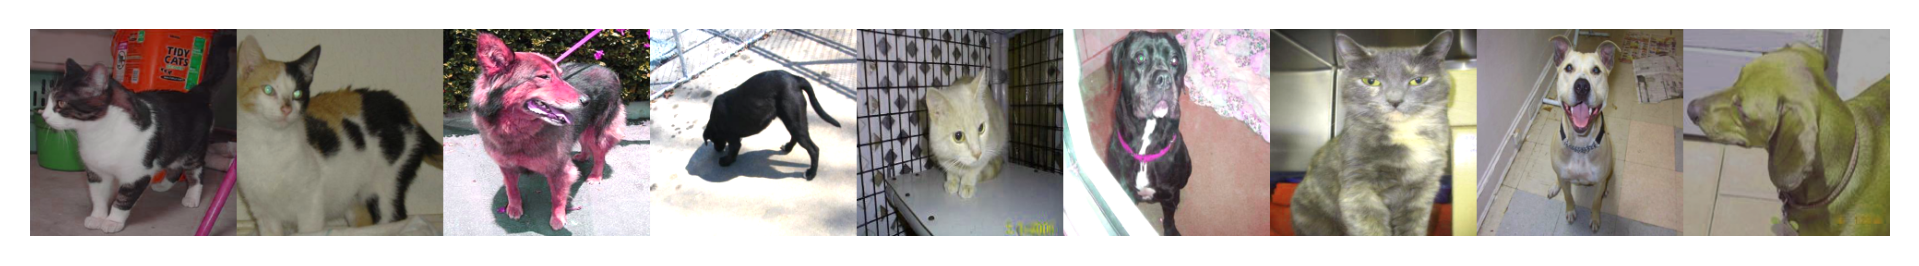

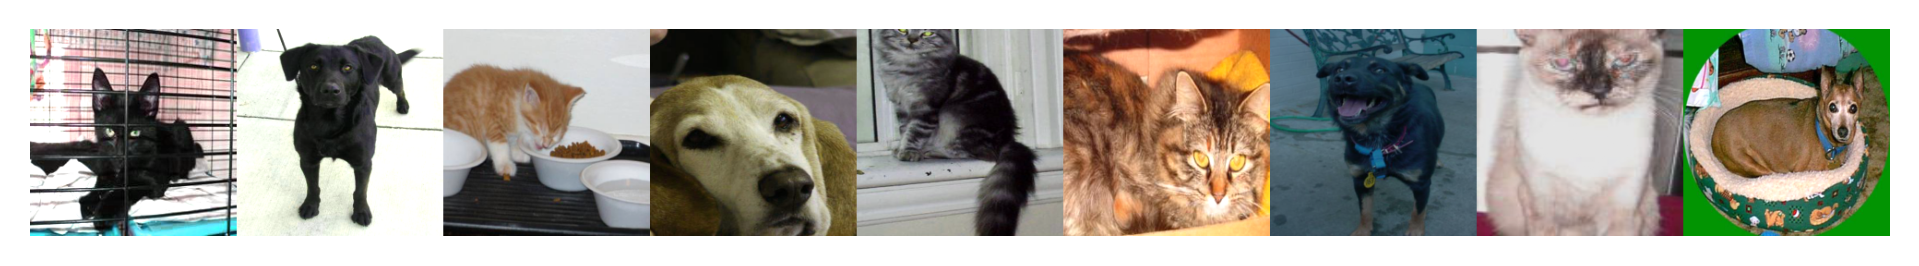

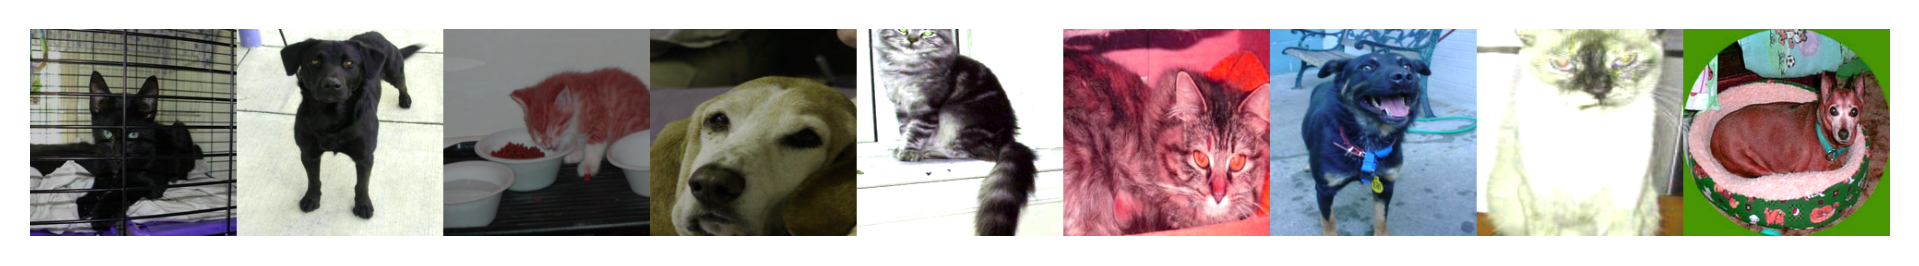

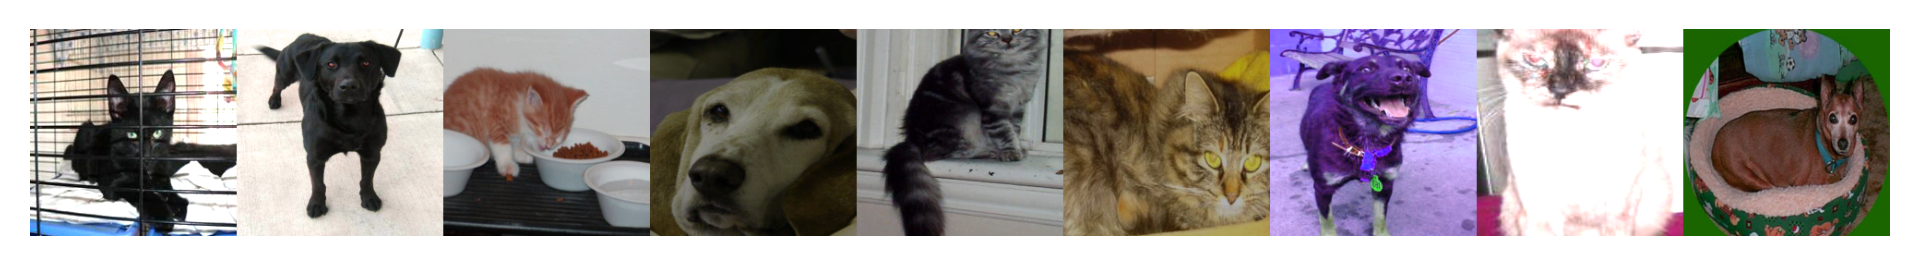

In [18]:
# this cell is here only because the Author apprently didn't understand how Dataset and Dataloaders behave - are they iterable, are they generators? - well they are hybrid. - , and wanted to see what happens
# all but one cell can be commented
# TODO: you don't need a separate loader. each iteration goes from the beginning
# but its interesting that different augmentations get generated.
iterator = iter(vis_train_loader)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))

In [19]:
print(len(train_data), len(train_loader), len(test_loader))

100 1 50


In [20]:
print(sum(1 for filename in train_data.file_list if 'cat' in filename))
print(sum(1 for filename in train_data.file_list if 'dog' in filename))
print(sum(1 for filename in val_data.file_list if 'cat' in filename))
print(sum(1 for filename in val_data.file_list if 'dog' in filename))
print(sum(1 for filename in test_data.file_list if 'cat' in filename))
print(sum(1 for filename in test_data.file_list if 'dog' in filename))

50
50
2500
2500
2500
2500


In [21]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
model = model.to(device)
model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [24]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
def eval_model(loader: torch.utils.data.dataloader.DataLoader, model: nn.Module, description: str="Evaluation:") -> tuple: #[torch.Tensor, torch.Tensor] detailed tuple types only in Python >3.9, colab has 3.8.16
  epoch_accuracy=0
  epoch_loss =0
  with torch.no_grad():
    with tqdm(loader, unit="iteration") as tqdm_wrapped_loader:
      tqdm_wrapped_loader.set_description(description)
      for data, label in tqdm_wrapped_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output,label)


          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/ len(loader)
          epoch_loss += loss/ len(loader)
          tqdm_wrapped_loader.set_postfix(epoch_accuracy=epoch_accuracy, loss=epoch_loss)
  return epoch_accuracy, epoch_loss

In [26]:
epochs = 100 #10
min_val_loss = float('inf')
epochs_since_min_loss = 0
patience = 7
final_scores = {}

for epoch in range(epochs):
    print("\n","="*30,"\n")
    epoch_loss = 0
    epoch_accuracy = 0
    
    with tqdm(train_loader, unit="iteration") as tepoch:
      
      for data, label in tepoch:
          tepoch.set_description(f"Training epoch {epoch}")
          data = data.to(device)
          label = label.to(device)
          
          output = model(data)
          loss = criterion(output, label)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)
          tepoch.set_postfix(loss=loss.item(), accuracy=100. * epoch_accuracy)
      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch, epoch_accuracy,epoch_loss))

    
      # with torch.no_grad():
      #     epoch_val_accuracy=0
      #     epoch_val_loss =0
      #     with tqdm(val_loader, unit="iteration") as tqdm_wrapped_valid_loader:
      #       tepoch.set_description(f"Validation after epoch {epoch}")
      #       for data, label in tqdm_wrapped_valid_loader:
      #           data = data.to(device)
      #           label = label.to(device)
                
      #           val_output = model(data)
      #           val_loss = criterion(val_output,label)
                
                
      #           acc = ((val_output.argmax(dim=1) == label).float().mean())
      #           epoch_val_accuracy += acc/ len(val_loader)
      #           epoch_val_loss += val_loss/ len(val_loader)
      #           tqdm_wrapped_valid_loader.set_postfix(epoch_val_accuracy=epoch_val_accuracy, val_loss=val_loss)
    epoch_val_accuracy,epoch_val_loss = eval_model(val_loader, model, f"Validation after epoch {epoch}")
    print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch, epoch_val_accuracy,epoch_val_loss))
    scalar_val_loss = epoch_val_loss.item()
    if scalar_val_loss < min_val_loss:
      min_val_loss = scalar_val_loss 
      epochs_since_min_loss = 0 
      final_scores['epoch']=epoch
      final_scores['epoch_train_accuracy']=epoch_accuracy
      final_scores['epoch_train_loss']=epoch_loss
      final_scores['epoch_val_loss']=epoch_val_loss
      final_scores['epoch_val_accuracy']=epoch_val_accuracy


      print("New best model, min_val_loss:", min_val_loss)


      # with torch.no_grad():
      #     epoch_test_accuracy=0
      #     epoch_test_loss =0
      #     with tqdm(test_loader, unit="iteration") as tqdm_wrapped_test_loader:
      #       tepoch.set_description(f"Test after epoch {epoch}")
      #       for data, label in tqdm_wrapped_test_loader:
      #           data = data.to(device)
      #           label = label.to(device)
                
      #           test_output = model(data)
      #           test_loss = criterion(test_output,label)
                
                
      #           acc = ((test_output.argmax(dim=1) == label).float().mean())
      #           epoch_test_accuracy += acc/ len(test_loader)
      #           epoch_test_loss += test_loss/ len(test_loader)
      #           tqdm_wrapped_test_loader.set_postfix(epoch_test_accuracy=epoch_test_accuracy, test_loss=test_loss)

      # epoch_test_accuracy,epoch_test_loss = eval_model(test_loader, model, f"Test after epoch {epoch}")
      # print('Epoch : {}, test_accuracy : {}, test_loss : {}'.format(epoch, epoch_test_accuracy,epoch_test_loss))



    else:
      epochs_since_min_loss+=1
      print("epochs_since_min_loss",epochs_since_min_loss)
    if epochs_since_min_loss > patience:
      print(f"Early stopping. \n\n Best model scores: {final_scores}")
      break

Training epoch 0: 100%|██████████| 1/1 [00:07<00:00,  7.77s/iteration, accuracy=tensor(0., device='cuda:0'), loss=6.99]


Epoch : 0, train accuracy : 0.0, train loss : 6.989992141723633


Validation after epoch 0: 100%|██████████| 50/50 [00:26<00:00,  1.88iteration/s, epoch_accuracy=tensor(0.5884, device='cuda:0'), loss=tensor(5.9487, device='cuda:0')]


Epoch : 0, val_accuracy : 0.5883998274803162, val_loss : 5.948709964752197
New best model, min_val_loss: 5.948709964752197




Training epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(53.0000, device='cuda:0'), loss=5.99]


Epoch : 1, train accuracy : 0.5299999713897705, train loss : 5.987412929534912


Validation after epoch 1: 100%|██████████| 50/50 [00:27<00:00,  1.82iteration/s, epoch_accuracy=tensor(0.5948, device='cuda:0'), loss=tensor(4.9105, device='cuda:0')]


Epoch : 1, val_accuracy : 0.5947998762130737, val_loss : 4.91050910949707
New best model, min_val_loss: 4.91050910949707




Training epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.32s/iteration, accuracy=tensor(54.0000, device='cuda:0'), loss=4.96]


Epoch : 2, train accuracy : 0.5399999618530273, train loss : 4.962931156158447


Validation after epoch 2: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.5954, device='cuda:0'), loss=tensor(3.9139, device='cuda:0')]


Epoch : 2, val_accuracy : 0.5953998565673828, val_loss : 3.913938283920288
New best model, min_val_loss: 3.913938283920288




Training epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.30s/iteration, accuracy=tensor(58., device='cuda:0'), loss=3.96]


Epoch : 3, train accuracy : 0.5799999833106995, train loss : 3.959625244140625


Validation after epoch 3: 100%|██████████| 50/50 [00:27<00:00,  1.79iteration/s, epoch_accuracy=tensor(0.6002, device='cuda:0'), loss=tensor(2.9499, device='cuda:0')]


Epoch : 3, val_accuracy : 0.6001999378204346, val_loss : 2.9498672485351562
New best model, min_val_loss: 2.9498672485351562




Training epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.30s/iteration, accuracy=tensor(59.0000, device='cuda:0'), loss=2.95]


Epoch : 4, train accuracy : 0.5899999737739563, train loss : 2.9535369873046875


Validation after epoch 4: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.6024, device='cuda:0'), loss=tensor(2.0732, device='cuda:0')]


Epoch : 4, val_accuracy : 0.602400004863739, val_loss : 2.073190212249756
New best model, min_val_loss: 2.073190212249756




Training epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(61., device='cuda:0'), loss=2.07]


Epoch : 5, train accuracy : 0.6100000143051147, train loss : 2.0695228576660156


Validation after epoch 5: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.6020, device='cuda:0'), loss=tensor(1.4289, device='cuda:0')]


Epoch : 5, val_accuracy : 0.6019998788833618, val_loss : 1.4288768768310547
New best model, min_val_loss: 1.4288768768310547




Training epoch 6: 100%|██████████| 1/1 [00:01<00:00,  1.31s/iteration, accuracy=tensor(56., device='cuda:0'), loss=1.42]


Epoch : 6, train accuracy : 0.5600000023841858, train loss : 1.415356159210205


Validation after epoch 6: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.5876, device='cuda:0'), loss=tensor(1.0459, device='cuda:0')]


Epoch : 6, val_accuracy : 0.5875999927520752, val_loss : 1.0458695888519287
New best model, min_val_loss: 1.0458695888519287




Training epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.31s/iteration, accuracy=tensor(52., device='cuda:0'), loss=1.08]


Epoch : 7, train accuracy : 0.5199999809265137, train loss : 1.080313801765442


Validation after epoch 7: 100%|██████████| 50/50 [00:26<00:00,  1.88iteration/s, epoch_accuracy=tensor(0.4760, device='cuda:0'), loss=tensor(0.9142, device='cuda:0')]


Epoch : 7, val_accuracy : 0.47600001096725464, val_loss : 0.9141733646392822
New best model, min_val_loss: 0.9141733646392822




Training epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.31s/iteration, accuracy=tensor(51., device='cuda:0'), loss=0.903]


Epoch : 8, train accuracy : 0.5099999904632568, train loss : 0.9032673835754395


Validation after epoch 8: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.5416, device='cuda:0'), loss=tensor(0.7804, device='cuda:0')]


Epoch : 8, val_accuracy : 0.5415998697280884, val_loss : 0.7804311513900757
New best model, min_val_loss: 0.7804311513900757




Training epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.30s/iteration, accuracy=tensor(49.0000, device='cuda:0'), loss=0.742]


Epoch : 9, train accuracy : 0.4899999797344208, train loss : 0.7419582605361938


Validation after epoch 9: 100%|██████████| 50/50 [00:26<00:00,  1.87iteration/s, epoch_accuracy=tensor(0.5620, device='cuda:0'), loss=tensor(0.7257, device='cuda:0')]


Epoch : 9, val_accuracy : 0.5619999766349792, val_loss : 0.7256859540939331
New best model, min_val_loss: 0.7256859540939331




Training epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.28s/iteration, accuracy=tensor(59.0000, device='cuda:0'), loss=0.695]


Epoch : 10, train accuracy : 0.5899999737739563, train loss : 0.69455885887146


Validation after epoch 10: 100%|██████████| 50/50 [00:27<00:00,  1.80iteration/s, epoch_accuracy=tensor(0.5840, device='cuda:0'), loss=tensor(0.7047, device='cuda:0')]


Epoch : 10, val_accuracy : 0.5839999318122864, val_loss : 0.7046756744384766
New best model, min_val_loss: 0.7046756744384766




Training epoch 11: 100%|██████████| 1/1 [00:01<00:00,  1.31s/iteration, accuracy=tensor(62., device='cuda:0'), loss=0.695]


Epoch : 11, train accuracy : 0.6200000047683716, train loss : 0.6951214671134949


Validation after epoch 11: 100%|██████████| 50/50 [00:26<00:00,  1.89iteration/s, epoch_accuracy=tensor(0.5838, device='cuda:0'), loss=tensor(0.6908, device='cuda:0')]


Epoch : 11, val_accuracy : 0.5838000178337097, val_loss : 0.6908214092254639
New best model, min_val_loss: 0.6908214092254639




Training epoch 12: 100%|██████████| 1/1 [00:01<00:00,  1.28s/iteration, accuracy=tensor(62., device='cuda:0'), loss=0.653]


Epoch : 12, train accuracy : 0.6200000047683716, train loss : 0.6529656052589417


Validation after epoch 12: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.5668, device='cuda:0'), loss=tensor(0.6868, device='cuda:0')]


Epoch : 12, val_accuracy : 0.5667999982833862, val_loss : 0.6867918372154236
New best model, min_val_loss: 0.6867918372154236




Training epoch 13: 100%|██████████| 1/1 [00:01<00:00,  1.28s/iteration, accuracy=tensor(61., device='cuda:0'), loss=0.653]


Epoch : 13, train accuracy : 0.6100000143051147, train loss : 0.6528704166412354


Validation after epoch 13: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.5332, device='cuda:0'), loss=tensor(0.6975, device='cuda:0')]


Epoch : 13, val_accuracy : 0.5331999659538269, val_loss : 0.6974618434906006
epochs_since_min_loss 1




Training epoch 14: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(64., device='cuda:0'), loss=0.664]


Epoch : 14, train accuracy : 0.6399999856948853, train loss : 0.6635322570800781


Validation after epoch 14: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.4970, device='cuda:0'), loss=tensor(0.7286, device='cuda:0')]


Epoch : 14, val_accuracy : 0.4970000684261322, val_loss : 0.7286402583122253
epochs_since_min_loss 2




Training epoch 15: 100%|██████████| 1/1 [00:01<00:00,  1.28s/iteration, accuracy=tensor(55., device='cuda:0'), loss=0.668]


Epoch : 15, train accuracy : 0.550000011920929, train loss : 0.6679788827896118


Validation after epoch 15: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.5072, device='cuda:0'), loss=tensor(0.7208, device='cuda:0')]


Epoch : 15, val_accuracy : 0.5072000026702881, val_loss : 0.7207909822463989
epochs_since_min_loss 3




Training epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.31s/iteration, accuracy=tensor(60.0000, device='cuda:0'), loss=0.659]


Epoch : 16, train accuracy : 0.5999999642372131, train loss : 0.6586889624595642


Validation after epoch 16: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.5408, device='cuda:0'), loss=tensor(0.7000, device='cuda:0')]


Epoch : 16, val_accuracy : 0.5407999157905579, val_loss : 0.6999627947807312
epochs_since_min_loss 4




Training epoch 17: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(59.0000, device='cuda:0'), loss=0.663]


Epoch : 17, train accuracy : 0.5899999737739563, train loss : 0.6633023023605347


Validation after epoch 17: 100%|██████████| 50/50 [00:27<00:00,  1.84iteration/s, epoch_accuracy=tensor(0.5950, device='cuda:0'), loss=tensor(0.6681, device='cuda:0')]


Epoch : 17, val_accuracy : 0.5949999094009399, val_loss : 0.6681100726127625
New best model, min_val_loss: 0.6681100726127625




Training epoch 18: 100%|██████████| 1/1 [00:01<00:00,  1.28s/iteration, accuracy=tensor(64., device='cuda:0'), loss=0.63]


Epoch : 18, train accuracy : 0.6399999856948853, train loss : 0.6298034191131592


Validation after epoch 18: 100%|██████████| 50/50 [00:26<00:00,  1.90iteration/s, epoch_accuracy=tensor(0.6080, device='cuda:0'), loss=tensor(0.6644, device='cuda:0')]


Epoch : 18, val_accuracy : 0.6079999208450317, val_loss : 0.6643998622894287
New best model, min_val_loss: 0.6643998622894287




Training epoch 19: 100%|██████████| 1/1 [00:01<00:00,  1.30s/iteration, accuracy=tensor(67.0000, device='cuda:0'), loss=0.601]


Epoch : 19, train accuracy : 0.6699999570846558, train loss : 0.6008405685424805


Validation after epoch 19: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.6090, device='cuda:0'), loss=tensor(0.6654, device='cuda:0')]


Epoch : 19, val_accuracy : 0.6089999079704285, val_loss : 0.6654120087623596
epochs_since_min_loss 1




Training epoch 20: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(64., device='cuda:0'), loss=0.626]


Epoch : 20, train accuracy : 0.6399999856948853, train loss : 0.6259222030639648


Validation after epoch 20: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.5940, device='cuda:0'), loss=tensor(0.6774, device='cuda:0')]


Epoch : 20, val_accuracy : 0.5939998626708984, val_loss : 0.677436351776123
epochs_since_min_loss 2




Training epoch 21: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(73.0000, device='cuda:0'), loss=0.565]


Epoch : 21, train accuracy : 0.7299999594688416, train loss : 0.5646154880523682


Validation after epoch 21: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.5704, device='cuda:0'), loss=tensor(0.7061, device='cuda:0')]


Epoch : 21, val_accuracy : 0.5703999996185303, val_loss : 0.7061291933059692
epochs_since_min_loss 3




Training epoch 22: 100%|██████████| 1/1 [00:01<00:00,  1.27s/iteration, accuracy=tensor(70., device='cuda:0'), loss=0.59]


Epoch : 22, train accuracy : 0.699999988079071, train loss : 0.5904863476753235


Validation after epoch 22: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.5566, device='cuda:0'), loss=tensor(0.7335, device='cuda:0')]


Epoch : 22, val_accuracy : 0.5566000938415527, val_loss : 0.7335216999053955
epochs_since_min_loss 4




Training epoch 23: 100%|██████████| 1/1 [00:01<00:00,  1.27s/iteration, accuracy=tensor(66., device='cuda:0'), loss=0.574]


Epoch : 23, train accuracy : 0.6599999666213989, train loss : 0.5738287568092346


Validation after epoch 23: 100%|██████████| 50/50 [00:27<00:00,  1.84iteration/s, epoch_accuracy=tensor(0.5704, device='cuda:0'), loss=tensor(0.7305, device='cuda:0')]


Epoch : 23, val_accuracy : 0.5703999996185303, val_loss : 0.7305378317832947
epochs_since_min_loss 5




Training epoch 24: 100%|██████████| 1/1 [00:01<00:00,  1.27s/iteration, accuracy=tensor(74., device='cuda:0'), loss=0.567]


Epoch : 24, train accuracy : 0.7400000095367432, train loss : 0.5665852427482605


Validation after epoch 24: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.5890, device='cuda:0'), loss=tensor(0.7102, device='cuda:0')]


Epoch : 24, val_accuracy : 0.58899986743927, val_loss : 0.7101544737815857
epochs_since_min_loss 6




Training epoch 25: 100%|██████████| 1/1 [00:01<00:00,  1.29s/iteration, accuracy=tensor(70., device='cuda:0'), loss=0.598]


Epoch : 25, train accuracy : 0.699999988079071, train loss : 0.5981252789497375


Validation after epoch 25: 100%|██████████| 50/50 [00:26<00:00,  1.91iteration/s, epoch_accuracy=tensor(0.5914, device='cuda:0'), loss=tensor(0.7075, device='cuda:0')]


Epoch : 25, val_accuracy : 0.5913999676704407, val_loss : 0.7075415253639221
epochs_since_min_loss 7




Training epoch 26: 100%|██████████| 1/1 [00:01<00:00,  1.27s/iteration, accuracy=tensor(74., device='cuda:0'), loss=0.528]


Epoch : 26, train accuracy : 0.7400000095367432, train loss : 0.5276871919631958


Validation after epoch 26: 100%|██████████| 50/50 [00:25<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.5740, device='cuda:0'), loss=tensor(0.7273, device='cuda:0')]

Epoch : 26, val_accuracy : 0.5740000009536743, val_loss : 0.7273452281951904
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}


In [27]:
print(f"Early stopping. \n\n Best model scores: {final_scores}")

Early stopping. 

 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}


In [28]:
dog_probs = []
model.eval()
i=0
with torch.no_grad():b
  for data, fileid in val_loader:
      i+=1
      if i>10:
        break
      data = data.to(device)
      preds = model(data)
      print(preds)
      preds_list = F.softmax(preds, dim=1)[:, 1].tolist() #https://stats.stackexchange.com/questions/542054/why-does-torchvision-models-resnet18-not-use-softmax
      dog_probs += list(zip(list(fileid), preds_list))

IndentationError: ignored

# Future experiments
1000 imgs set; or more intervals; saturate cheap experiments space.

no test
no random crop augmentation
# Results

batch=100, patience=7
============

2000 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: 
 {'epoch': 33, 'epoch_train_accuracy': tensor(0.8380, device='cuda:0'), 'epoch_train_loss': tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3896, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8188, device='cuda:0')}

Training epoch 33: 100%|██████████| 20/20 [00:25<00:00,  1.30s/iteration, accuracy=tensor(83.8000, device='cuda:0'), loss=0.395]
Epoch : 33, train accuracy : 0.8380000591278076, train loss : 0.3545871675014496
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_val_accuracy=tensor(0.8188, device='cuda:0'), val_loss=tensor(0.4697, device='cuda:0')]
Epoch : 33, val_accuracy : 0.8188000321388245, val_loss : 0.3895597457885742
New best model, min_val_loss: 0.3895597457885742



================================================

500 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: {'epoch': 39, 'epoch_train_accuracy': tensor(0.7480, device='cuda:0'), 'epoch_train_loss': tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5940, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6928, device='cuda:0')}


Training epoch 39: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(74.8000, device='cuda:0'), loss=0.504]
Epoch : 39, train accuracy : 0.7479999661445618, train loss : 0.5132189393043518
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.6928, device='cuda:0'), val_loss=tensor(0.6708, device='cuda:0')]
Epoch : 39, val_accuracy : 0.6927998661994934, val_loss : 0.5940383076667786
New best model, min_val_loss: 0.5940383076667786
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_test_accuracy=tensor(0.6874, device='cuda:0'), test_loss=tensor(0.6752, device='cuda:0')]
Epoch : 39, test_accuracy : 0.6873999238014221, test_loss : 0.5957822799682617

================================================

500 imgs train set,
no transforms (only totensor)
fails with wrong shapes

================================================

500 imgs train set, only 224 resize
 transforms.Resize((224, 224)),


 Best model scores: {'epoch': 2, 'epoch_train_accuracy': tensor(0.6660, device='cuda:0'), 'epoch_train_loss': tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6951, device='cuda:0'), 'epoch_val_accuracy': tensor(0.5774, device='cuda:0')}


 Training epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.28iteration/s, accuracy=tensor(66.6000, device='cuda:0'), loss=0.627]
Epoch : 2, train accuracy : 0.6660000085830688, train loss : 0.6177714467048645
100%|██████████| 50/50 [00:27<00:00,  1.85iteration/s, epoch_val_accuracy=tensor(0.5774, device='cuda:0'), val_loss=tensor(0.7848, device='cuda:0')]
Epoch : 2, val_accuracy : 0.5773999691009521, val_loss : 0.6951212882995605
New best model, min_val_loss: 0.6951212882995605
100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_test_accuracy=tensor(0.5704, device='cuda:0'), test_loss=tensor(0.7834, device='cuda:0')]
Epoch : 2, test_accuracy : 0.5703999996185303, test_loss : 0.6962302327156067

note: patience in my implementation (> patience) means 8 more epochs get executed.








========================================


full train set


Training epoch 40: 100%|██████████| 150/150 [03:28<00:00,  1.39s/iteration, accuracy=tensor(96.8067, device='cuda:0'), loss=0.0306]
Epoch : 40, train accuracy : 0.9680668115615845, train loss : 0.07920999079942703
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.9506, device='cuda:0'), val_loss=tensor(0.1377, device='cuda:0')]
Epoch : 40, val_accuracy : 0.9506001472473145, val_loss : 0.12937913835048676
New best model, min_val_loss: 0.12937913835048676
100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_test_accuracy=tensor(0.9522, device='cuda:0'), test_loss=tensor(0.1373, device='cuda:0')]
Epoch : 40, test_accuracy : 0.9522001147270203, test_loss : 0.12997546792030334

 Best model scores: {'epoch': 40, 'epoch_train_accuracy': tensor(0.9681, device='cuda:0'), 'epoch_train_loss': tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.1294, device='cuda:0'), 'epoch_val_accuracy': tensor(0.9506, device='cuda:0')}



 ============================== 

 4000 imgs
 

Training epoch 56: 100%|██████████| 40/40 [00:50<00:00,  1.26s/iteration, accuracy=tensor(95.7750, device='cuda:0'), loss=0.112]
Epoch : 56, train accuracy : 0.9577500224113464, train loss : 0.10647499561309814
Validation after epoch 56: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.8970, device='cuda:0'), loss=tensor(0.2677, device='cuda:0')]Epoch : 56, val_accuracy : 0.8970000147819519, val_loss : 0.26771894097328186
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 48, 'epoch_train_accuracy': tensor(0.9498, device='cuda:0'), 'epoch_train_loss': tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.2475, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8988, device='cuda:0')}


  ============================== 
1000 imgs
Training epoch 46: 100%|██████████| 10/10 [00:12<00:00,  1.25s/iteration, accuracy=tensor(82.7000, device='cuda:0'), loss=0.423]
Epoch : 46, train accuracy : 0.8270000219345093, train loss : 0.3939513862133026
Validation after epoch 46: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7390, device='cuda:0'), loss=tensor(0.5494, device='cuda:0')]Epoch : 46, val_accuracy : 0.7390000224113464, val_loss : 0.5493948459625244
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.7650, device='cuda:0'), 'epoch_train_loss': tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5249, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7464, device='cuda:0')}

[29]
0s
print(f"Early stopping. \n\n Best model scores: {final_scores}")
Early stopping. 

=============================================

300 train imgs


 Best model scores: {'epoch': 36, 'epoch_train_accuracy': tensor(0.7300, device='cuda:0'), 'epoch_train_loss': tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6209, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6694, device='cuda:0')}


 Training epoch 36: 100%|██████████| 3/3 [00:03<00:00,  1.25s/iteration, accuracy=tensor(73., device='cuda:0'), loss=0.505]
Epoch : 36, train accuracy : 0.7300000190734863, train loss : 0.5214951038360596
Validation after epoch 36: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6694, device='cuda:0'), loss=tensor(0.6209, device='cuda:0')]
Epoch : 36, val_accuracy : 0.6693997979164124, val_loss : 0.6209338903427124
New best model, min_val_loss: 0.6209338903427124



===================================

100 imgs train



 Best model scores: {'epoch': 26, 'epoch_train_accuracy': tensor(0.6100, device='cuda:0'), 'epoch_train_loss': tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6606, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6008, device='cuda:0')}










 ========================


 1000 imgs train 
 no random crop


 Training epoch 11: 100%|██████████| 10/10 [00:13<00:00,  1.32s/iteration, accuracy=tensor(66.1000, device='cuda:0'), loss=0.598]
Epoch : 11, train accuracy : 0.6610000133514404, train loss : 0.6124292612075806
Validation after epoch 11: 100%|██████████| 50/50 [00:28<00:00,  1.78iteration/s, epoch_accuracy=tensor(0.6646, device='cuda:0'), loss=tensor(0.6104, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6645999550819397, val_loss : 0.6103843450546265
New best model, min_val_loss: 0.6103843450546265


=======

4000 imgs no random crop

Best model scores: {'epoch': 21, 'epoch_train_accuracy': tensor(0.8915, device='cuda:0'), 'epoch_train_loss': tensor(0.2574, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4274, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8212, device='cuda:0')}



=======

4000 imgs random crop (0.9, 1.0)



 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.9482, device='cuda:0'), 'epoch_train_loss': tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3618, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8702, device='cuda:0')}


 =============

 300 (0.9,1.0)


 
 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}
